In [1]:
import pandas as pd
import numpy as np

# Paths to uploaded train/test
train_path = "train.csv"
test_path = "test.csv"

# Load
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

print(df_train.shape, df_test.shape)

# Combine for EDA (train/test column added)
df_train["dataset"] = "train"
df_test["dataset"] = "test"

df_full = pd.concat([df_train, df_test], ignore_index=True)

# Identify columns
feature_cols = [c for c in df_full.columns if c not in ["subject", "Activity", "activity", "dataset"]]

label_col = "Activity" if "Activity" in df_full.columns else "activity"

print("Num features:", len(feature_cols))

(7352, 563) (2947, 563)
Num features: 561


In [2]:
from collections import defaultdict

groups = defaultdict(list)

for col in feature_cols:
    if col.startswith("tBodyAcc"):
        groups["Time Body Acceleration"].append(col)
    elif col.startswith("tGravityAcc"):
        groups["Time Gravity Acceleration"].append(col)
    elif col.startswith("tBodyGyro"):
        groups["Time Body Gyroscope"].append(col)
    elif col.startswith("tBodyAccJerk"):
        groups["Time Body Acc Jerk"].append(col)
    elif col.startswith("tBodyGyroJerk"):
        groups["Time Body Gyro Jerk"].append(col)
    elif col.startswith("tBodyAccMag"):
        groups["Time Body Acc Magnitude"].append(col)
    elif col.startswith("fBodyAcc"):
        groups["Frequency Body Acc"].append(col)
    elif col.startswith("fBodyGyro"):
        groups["Frequency Body Gyro"].append(col)
    elif col.startswith("fBodyAccJerk"):
        groups["Frequency Body Acc Jerk"].append(col)
    elif col.startswith("fBodyGyroJerk"):
        groups["Frequency Body Gyro Jerk"].append(col)
    else:
        groups["Other"].append(col)

for g in groups:
    print(f"{g}: {len(groups[g])} features")

Time Body Acceleration: 106 features
Time Gravity Acceleration: 53 features
Time Body Gyroscope: 106 features
Frequency Body Acc: 171 features
Frequency Body Gyro: 79 features
Other: 46 features


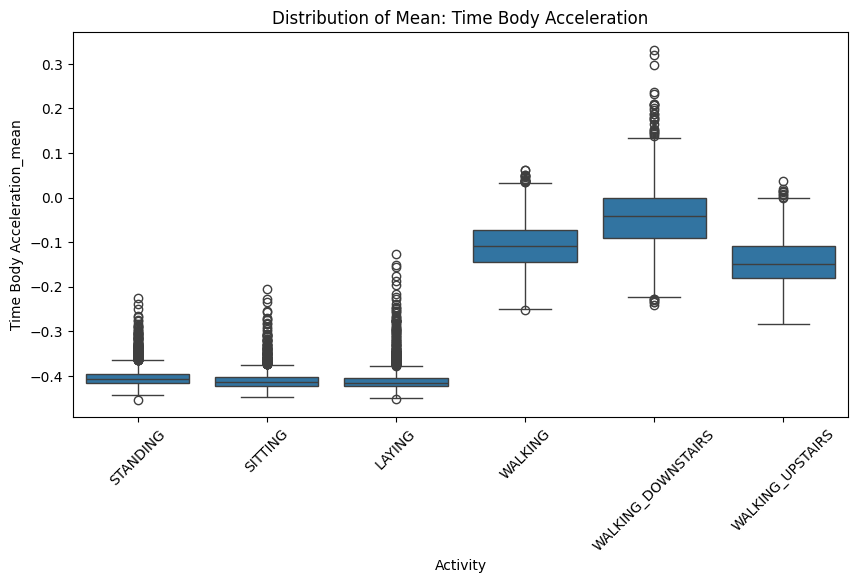

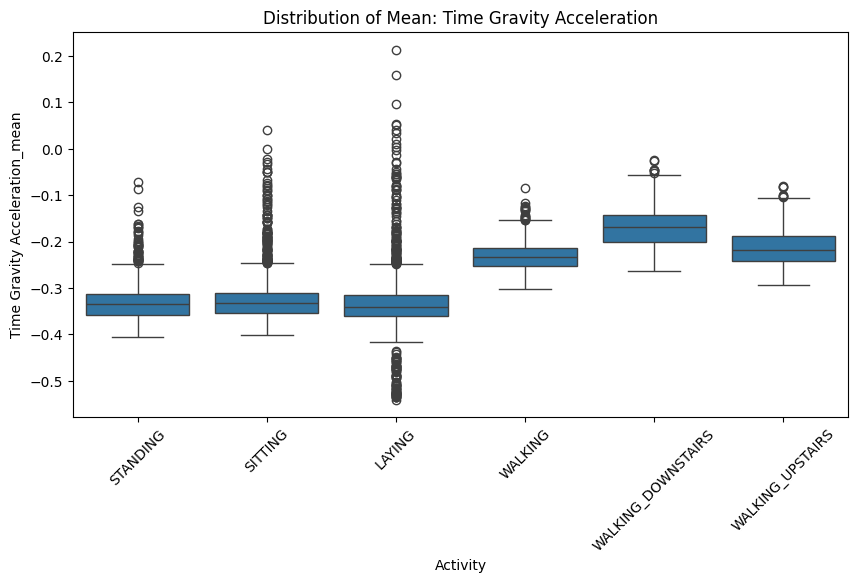

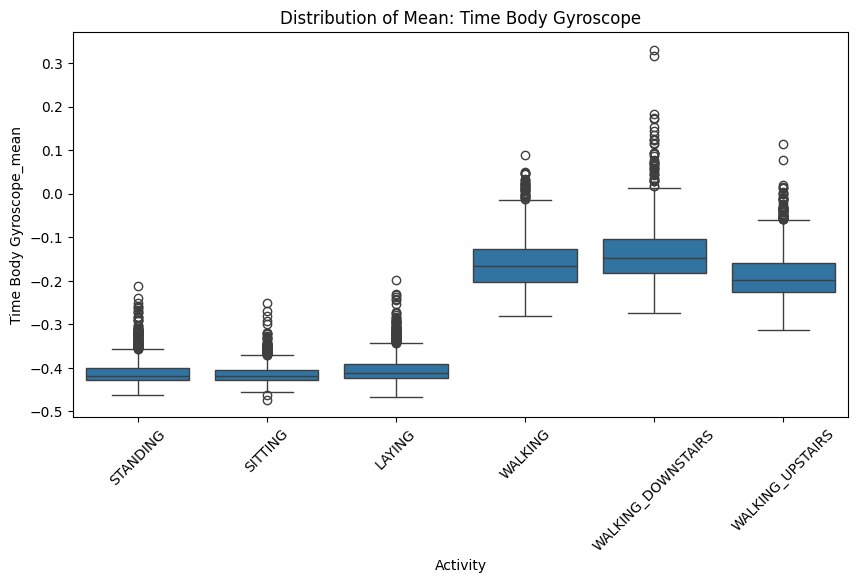

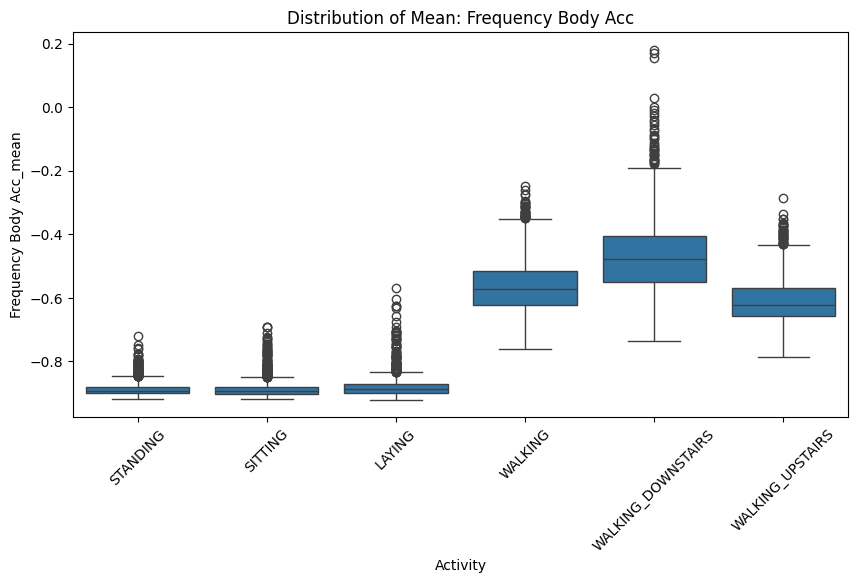

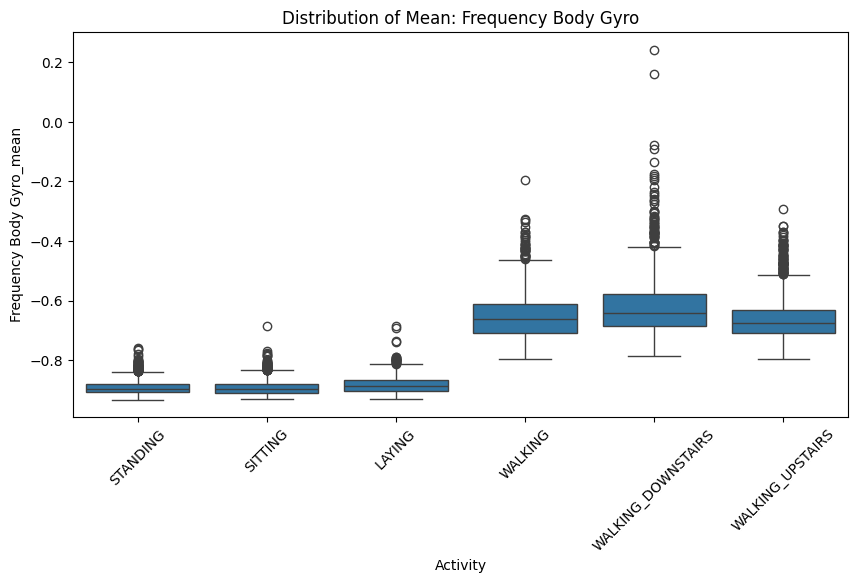

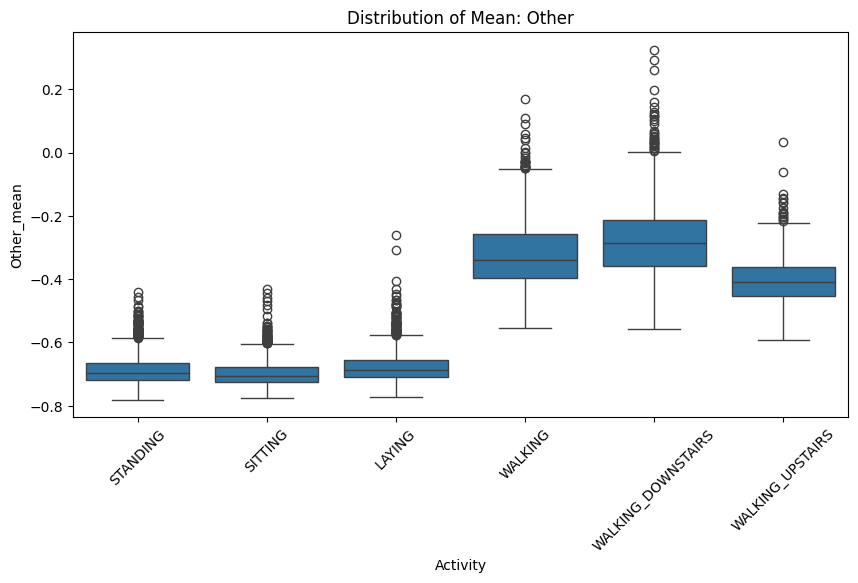

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

for group_name, cols in groups.items():
    if len(cols) == 0:
        continue
    
    df_full[group_name + "_mean"] = df_full[cols].mean(axis=1)
    df_full[group_name + "_var"] = df_full[cols].var(axis=1)

    plt.figure(figsize=(10,5))
    sns.boxplot(data=df_full, x=label_col, y=group_name + "_mean")
    plt.title(f"Distribution of Mean: {group_name}")
    plt.xticks(rotation=45)
    plt.show()

In [4]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale
X = df_full[feature_cols].values
y = df_full[label_col].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 50D for silhouette (561D is too large)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_scaled)

silhouette = silhouette_score(X_reduced, y)
print("Silhouette Score (0=overlap, 1=perfect separation):", silhouette)

Silhouette Score (0=overlap, 1=perfect separation): 0.04811837275484844


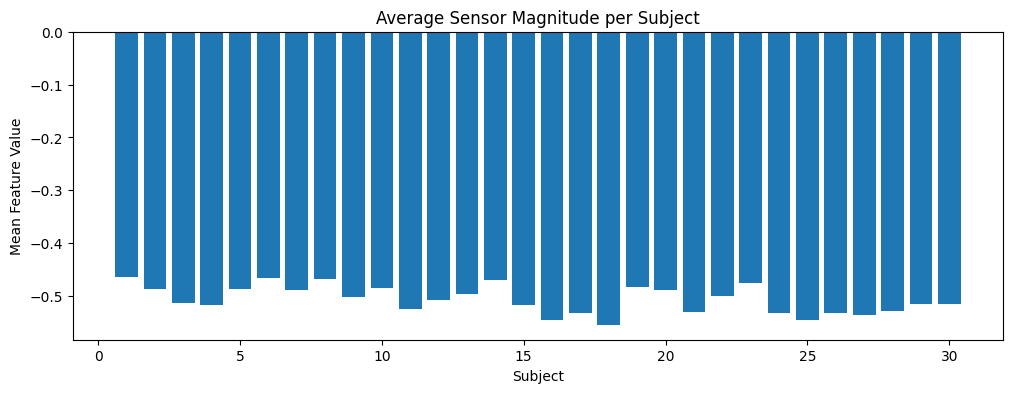

In [5]:
subjects = df_full["subject"].unique()
subject_means = {}

for s in subjects:
    subject_means[s] = df_full[df_full["subject"] == s][feature_cols].mean().mean()

plt.figure(figsize=(12,4))
plt.bar(subject_means.keys(), subject_means.values())
plt.title("Average Sensor Magnitude per Subject")
plt.xlabel("Subject")
plt.ylabel("Mean Feature Value")
plt.show()

tGravityAcc-mean()-X         0.041152
angle(X,gravityMean)         0.029464
tGravityAcc-mean()-Y         0.028996
tGravityAcc-min()-X          0.026000
tGravityAcc-max()-X          0.025390
tGravityAcc-energy()-X       0.024981
angle(Y,gravityMean)         0.023701
tGravityAcc-min()-Y          0.022208
tGravityAcc-max()-Y          0.018136
tGravityAcc-energy()-Y       0.016358
tGravityAcc-arCoeff()-Z,2    0.012289
tGravityAccMag-std()         0.012076
tBodyAccJerk-std()-X         0.011596
fBodyAccJerk-energy()-X      0.011206
angle(Z,gravityMean)         0.011059
fBodyAccJerk-max()-X         0.010787
fBodyAccMag-energy()         0.010139
tGravityAcc-arCoeff()-Z,3    0.009537
tGravityAcc-min()-Z          0.008897
tGravityAcc-energy()-Z       0.008631
dtype: float64


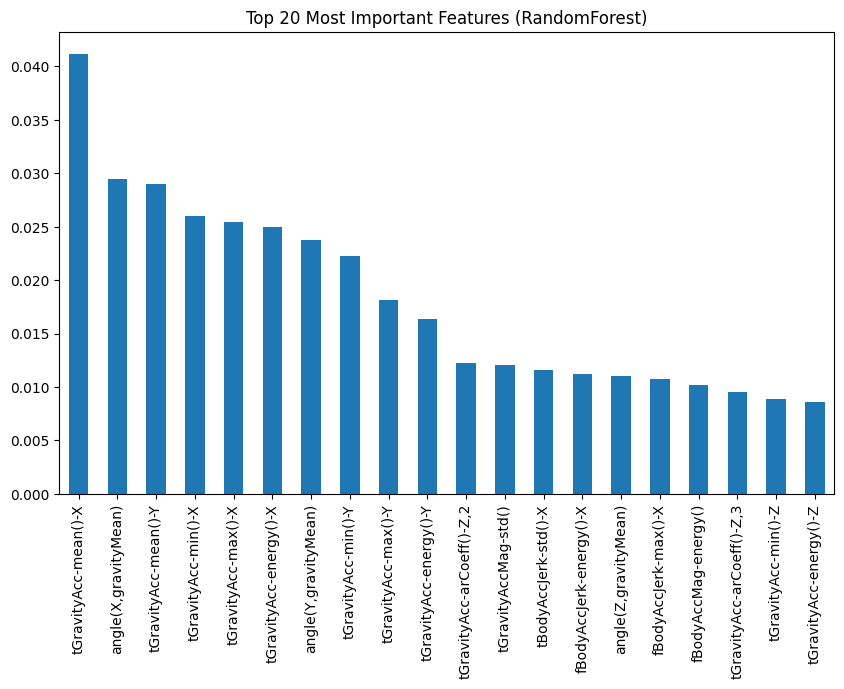

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
rf.fit(df_train[feature_cols], df_train[label_col])

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

print(importances.head(20))

plt.figure(figsize=(10,6))
importances.head(20).plot(kind="bar")
plt.title("Top 20 Most Important Features (RandomForest)")
plt.show()

tBodyAcc-max()-X                  1.006893
tGravityAcc-min()-Y               0.944219
tBodyAccJerk-max()-X              0.937857
tGravityAcc-max()-Y               0.928346
tBodyAccMag-max()                 0.904677
tGravityAccMag-max()              0.904643
tBodyAccJerk-max()-Y              0.892837
fBodyAcc-std()-X                  0.890931
fBodyAcc-bandsEnergy()-1,16       0.890793
fBodyAcc-bandsEnergy()-1,8        0.887700
tBodyAccJerkMag-max()             0.878195
tBodyAcc-min()-X                  0.877266
tBodyAcc-energy()-X               0.875399
fBodyAcc-energy()-X               0.874665
tBodyAcc-std()-X                  0.874634
fBodyAcc-bandsEnergy()-1,24       0.872278
tBodyAcc-mad()-X                  0.869271
fBodyAccJerk-bandsEnergy()-1,8    0.869113
fBodyAcc-mad()-X                  0.863242
fBodyAcc-max()-X                  0.861397
dtype: float64


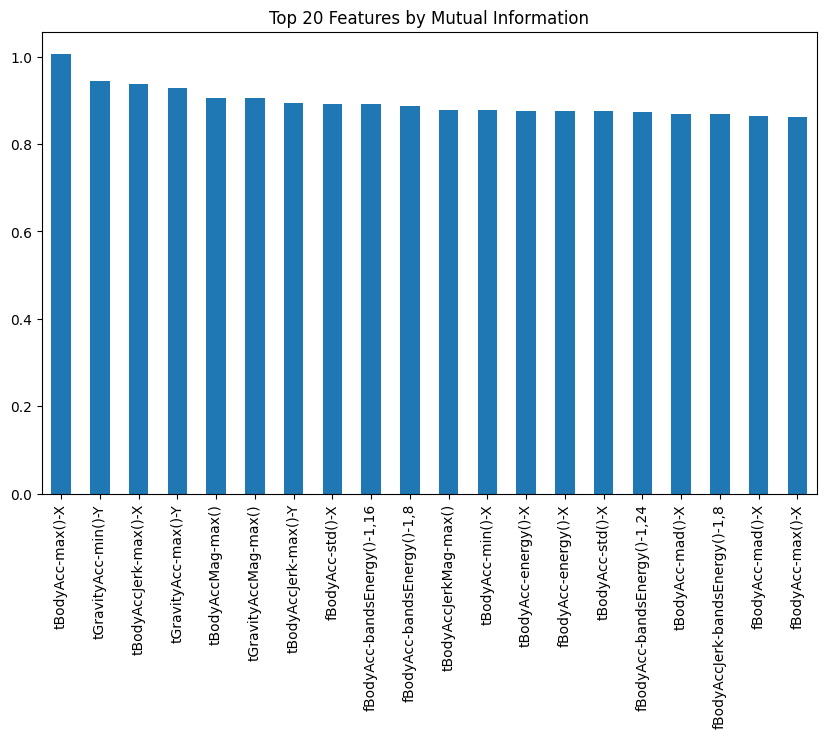

In [7]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(df_train[feature_cols], df_train[label_col], random_state=42)
mi_series = pd.Series(mi, index=feature_cols).sort_values(ascending=False)

print(mi_series.head(20))

plt.figure(figsize=(10,6))
mi_series.head(20).plot(kind="bar")
plt.title("Top 20 Features by Mutual Information")
plt.show()

In [8]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_reduced)

from sklearn.metrics import adjusted_rand_score
score = adjusted_rand_score(y, cluster_labels)
print("Cluster-to-Activity Alignment (ARI score):", score)

Cluster-to-Activity Alignment (ARI score): 0.2955853685735695


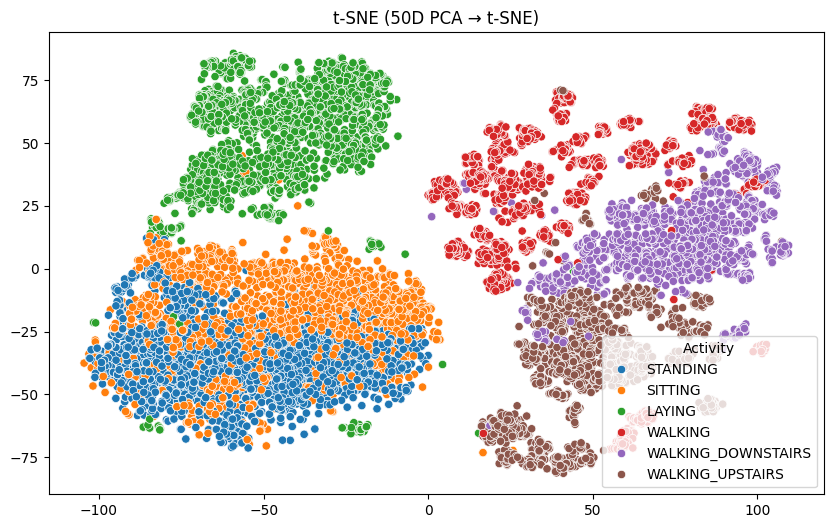

In [10]:
from sklearn.manifold import TSNE

X_tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    max_iter=2000,
    random_state=42
).fit_transform(X_reduced)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_full[label_col], palette="tab10")
plt.title("t-SNE (50D PCA → t-SNE)")
plt.show()